In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier

import xgboost as xgb
import plotly
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go

## Read data

In [10]:
df = pd.read_csv('C:/Temp/all_real_quad_fields.csv')

In [5]:
# Columns are:
# 'defining_polynomial'
# 'class_number'
# 'discriminant'
# 'res_s=0'
# 'number_roots_unity'
# 'regulator'
# 'a_1', 'a_2', 'a_3', ..., 'a_1000'

#print(df.columns.tolist())
#print(df.iloc[0:3, np.r_[0,1,2,3,4,5,6,7,8,9,10,11:13]])

In [3]:
print(df.iloc[0:3, np.r_[0,1,2]])

  defining_polynomial  class_number  discriminant
0         x^2 - x - 1             1           5.0
1             x^2 - 2             1           8.0
2             x^2 - 3             1          12.0


In [3]:
print(df.class_number.value_counts()[:8])

2     183432
1     177159
4     120440
8      45756
6      25395
3      25201
12     16495
16     13583
Name: class_number, dtype: int64


In [26]:
df_all = df[df.class_number <= 8]
#df_all = df

In [27]:
NEW_CLASS_NAME_ONE = 0
NEW_CLASS_NAME_TWO = 1
NEW_CLASS_NAME_THREE = 2
NEW_CLASS_NAME_FOUR = 3
NEW_CLASS_NAME_FIVE = 4
df_all.class_number.replace(1, NEW_CLASS_NAME_ONE, inplace=True)
df_all.class_number.replace(2, NEW_CLASS_NAME_TWO, inplace=True)
df_all.class_number.replace(3, NEW_CLASS_NAME_THREE, inplace=True)
df_all.class_number.replace(4, NEW_CLASS_NAME_FOUR, inplace=True)
df_all.loc[df_all.class_number > 4, 'class_number'] = NEW_CLASS_NAME_FIVE

In [28]:
print(df.class_number.value_counts()[:8])

1    183432
4    178903
0    177159
3    120440
2     25201
Name: class_number, dtype: int64


In [14]:
# For logistic regression we reduce the data set to class_number<2
df_all = df_all[df_all.class_number <= 1]
print(df_all.class_number.value_counts()[:8])

1    183432
0    177159
Name: class_number, dtype: int64


### Split data in train and test

In [15]:
# column 1 contains class values
predict_col = 1
df_train, df_test = train_test_split(df_all, test_size=0.3, stratify=df_all.iloc[:, predict_col])

#predict_col = 11
#df_train, df_test = train_test_split(df_all, test_size=0.9, stratify=df_all.iloc[:, predict_col])

## Achtung

X_test und y_test werden mehrfach verwendet, sind also keine echten Testdaten sondern Validierungsdaten

X_train, X_test => Features <br>
y_train, y_test => Klassen / Labels <br>

In [16]:
#col_train = np.r_[2,3,4,5,6:1006]
#col_train = np.r_[6:10]
col_train = np.r_[6:1006]

# column to predict is 'class_number' (1st column)
# column indexing is zero-based
y_train = df_train.iloc[:, predict_col]
y_test = df_test.iloc[:, predict_col]

# matrix of explanatory variables includes
X_train = df_train.iloc[:, col_train]
X_test = df_test.iloc[:, col_train]

## Training

### Logistic Regression

In [17]:
LR = LogisticRegression(random_state=0, solver='lbfgs').fit(X_train, y_train)
print(LR.score(X_test, y_test))

C:\Development\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



0.7095157980365694


### Support Vector Machine / Regression

In [12]:
df_reduced = df_all.sample(100)
# column 3 contains class values
df_train_reduced, df_test_reduced = train_test_split(df_reduced, test_size=0.2, stratify=df_reduced.iloc[:, 2])
col_train = np.r_[1,2,7,8,9,10,11:15]

# column to predict is 'class_number' (3rd column)
# column indexing is zero-based
y_train_reduced = df_train_reduced.iloc[:,2]
y_test_reduced = df_test_reduced.iloc[:,2]

# matrix of explanatory variables includes
X_train_reduced = df_train_reduced.iloc[:, col_train]
X_test_reduced = df_test_reduced.iloc[:, col_train]

svc_lin = svm.LinearSVC()
svc_nu = svm.NuSVC(gamma='auto')
svr_rbf = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=.1)
svr_lin = SVR(kernel='linear', C=100, gamma='auto')
svr_poly = SVR(kernel='poly', C=100, gamma='auto', degree=3, epsilon=.1, coef0=1, cache_size=300)
svr_poly.fit(X_train_reduced, y_train_reduced)

score = svr_poly.score(X_test_reduced, y_test_reduced)
print(score)

### Random Forest Classifier

In [21]:
RF = RandomForestClassifier(n_estimators=10, random_state=0).fit(X_train, y_train)
print(RF.score(X_test, y_test))

0.7186766255615744


### Decision Tree Classifier

In [22]:
DT = DecisionTreeClassifier().fit(X_train, y_train)
print(DT.score(X_test, y_test))

0.6620384921148478


### MLP  (neural network)

In [23]:
MLP = MLPClassifier(hidden_layer_sizes=4, activation="relu", solver="adam", alpha=0.0001, learning_rate="adaptive", max_iter=100).fit(X_train, y_train)
print(MLP.score(X_test, y_test))

C:\Development\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.



0.7566233430087449


In [24]:
XGB = xgb.XGBClassifier(use_label_encoder=False, n_estimators=100, max_depth=8, learning_rate=0.1, subsample=0.5,
                        eval_metric="logloss").fit(X_train, y_train)
print(XGB.score(X_test, y_test))

0.8407809351254414


### Ada Boost Classifier

In [25]:
ADBoost = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=10).fit(X_train, y_train)
print(ADBoost.score(X_test, y_test))

0.6619645399249385


## Visualization

In [16]:
df_plot = df_all.sample(6000)

dr1 = go.Scatter3d(
    x=df_plot[df_plot['class_number'] == NEW_CLASS_NAME_ONE]['res_s=0'],
    y=df_plot[df_plot['class_number'] == NEW_CLASS_NAME_ONE]['regulator'],
    z=df_plot[df_plot['class_number'] == NEW_CLASS_NAME_ONE]['discriminant'],
    mode='markers',
    marker = dict(size=3,
                  color='rgb(255,0,0)',
                  line=dict(width=1)),
    name ='class_number_1'
)
dr2 = go.Scatter3d(
    x=df_plot[df_plot['class_number'] == NEW_CLASS_NAME_TWO]['res_s=0'],
    y=df_plot[df_plot['class_number'] == NEW_CLASS_NAME_TWO]['regulator'],
    z=df_plot[df_plot['class_number'] == NEW_CLASS_NAME_TWO]['discriminant'],
    mode='markers',
    marker = dict(size=3,
                  color='rgb(0,255,0)',
                  line=dict(width=1)),
    name ='class_number_2'
)
dr3 = go.Scatter3d(
    x=df_plot[df_plot['class_number'] == NEW_CLASS_NAME_THREE]['res_s=0'],
    y=df_plot[df_plot['class_number'] == NEW_CLASS_NAME_THREE]['regulator'],
    z=df_plot[df_plot['class_number'] == NEW_CLASS_NAME_THREE]['discriminant'],
    mode='markers',
    marker = dict(size=3,
                  color='rgb(0,0,255)',
                  line=dict(width=1)),
    name ='class_number_3'
)
dr4 = go.Scatter3d(
    x=df_plot[df_plot['class_number'] == NEW_CLASS_NAME_FOUR]['res_s=0'],
    y=df_plot[df_plot['class_number'] == NEW_CLASS_NAME_FOUR]['regulator'],
    z=df_plot[df_plot['class_number'] == NEW_CLASS_NAME_FOUR]['discriminant'],
    mode='markers',
    marker = dict(size=3,
                  color='rgb(0,0,0)',
                  line=dict(width=1)),
    name ='class_number_4'
)
data = [dr1, dr2, dr3, dr4]
layout = go.Layout(
    title='class_number',
    scene = dict(
        xaxis = dict(title='regulator'),
        yaxis = dict(title='discriminant'),
        zaxis = dict(title='residue at s=0'),)
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='class_number')

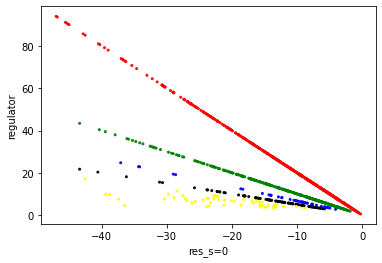

In [14]:
df_plot = df_all[df_all.class_number <= 4]
df_plot = df_plot.iloc[0:1000]
# df_plot = df_all
x = df_plot['res_s=0'].to_numpy()
y = df_plot['regulator'].to_numpy()
colors = df_all['class_number']
color_map = {0:'red', 1:'green', 2:'blue', 3:'black', 4:'yellow'}

f = plt.figure()
plt.scatter(x, y, s=4, alpha=0.9, c=df_plot.class_number.map(color_map))
# plt.title("class 1 (red) and class 2 (blue) for x^2 + bx + c")
plt.xlabel("res_s=0")
plt.ylabel("regulator")
plt.show()